In [1]:
def get_scanner(neg_llh, 
                use_multiple_vertex_seeds=False, 
                prescan_time=False,
                scale=100.,
                rtol=1e-8, 
                atol=1e-4):
    """Creates a scanner() function that performs a 2D profile likelihood 
    scan in the sky (direction). Note: The argumenst are used globally
    within functions defined in the body.
    
    Args
    ----
        neg_llh: A valid negative log likelihood function.
        use_multiple_vertex_seeds: If True, at each directional grid point, 
            the scanner will perform the vertex optimization from 
            additional vertex seeds.
            This increases robustness against local minima
            but increases the run-time 
        prescan_time: If True, the scanner will search for the best time 
            for a given vertex seed.
            This can improve convergence at the cost of run-time.
        scale: Re-scales the coordinate units during optimization.
            (maps step size of 1 to value of scale).
        rtol: relative tolerance of the optimizer (see optimistix.BFGS)
        atol: abolsute tolerance of the optimizer (see optimistix.BFGS)
            
    Returns
    -------
        scanner: A function that performs the likelihood scan
            according with the given properties / behavior.
    """
    
    # Vectorize likelihood along time argument.
    # Reminder: arguments are (direction, vertex, time, data).
    neg_llh_time_v = jax.vmap(neg_llh, (None, None, 0, None), 0)
    
    def get_track_time(track_dir, track_vertex, seed_time, data):
        """Find time that best matches the given vertex seed 
        and track direction. I.e. the time that yields the lowest 
        log likelihood value for the given track parameters.
        
        Args
        ----
            track_dir: jnp.array([zenith, azimuth]) in radians
            track_vertex: jnp.array([x, y, z]) in m
            seed_time: jnp.array(t) in ns
            data: jnp.array(data) with shape 
                (n_sensors, n_features) = (N, 5)
                
        Returns
        -------
            best_time: jnp.array(float)
        """
        dt = 100. # we search 100ns before and after seed_time
        nt = 20 # number of evaluation points
        time = jnp.linspace(seed_time - dt, seed_time + dt, nt)
        llh = neg_llh_time_v(track_dir, track_vertex, time, data)
        
        return time[jnp.argmin(llh, axis=0)]
    
    # Vectorize across vertex dimension. This allows performing
    # this operation for multiple vertex seeds at the 
    # given track direction.
    # Reminder: arguments are (direction, vertex, time, data).
    get_track_time_v = jax.vmap(
        get_track_time, 
        (None, 0, None, None), 
        0
    )

    # Define the likelihood function for the vertex optimization
    def neg_llh_vertex(x, args):
        """Defines the likelihood as function of the vertex.
        Consider any other arguments (args) as constant.
        
        Args
        ----
            x: jnp.array([x, y, z]), the current vertex.
            args: a tuple (track_dir, track_time, data)
            
        Returns
        -------
            Negative log-likelihood value.
        """
        pars, data = args
        track_dir = pars[:3]
        track_time = pars[3]

        x_prime = x * scale
        
        return neg_llh(track_dir, x_prime, track_time, data)
    
    def reconstruct_vertex(vertex_seed, track_dir, track_time, data):
        """Performs a single vertex reconstruction.
        
        Args
        ----
        vertex_seed: jnp.array([x, y, z]) in m
        track_dir: jnp.array([zenith, azimuth]) in radians
        track_time: jnp.array(t) in ns
        data: jnp.array(data) with shape 
                (n_sensors, n_features) = (N, 5)
            
        Returns
        -------
            Best-fit Negative loglikelihood value (neglogl) and 
            corresponding vertex as tuple(jnp.array, jnp.array([x,y,z]).
        """
        solver = optx.BestSoFarMinimiser(optx.BFGS(rtol=rtol, atol=atol, use_inverse=True))
        pars = jnp.concatenate([track_dir, jnp.expand_dims(track_time, axis=0)])
        args = (pars, data)
        sol = optx.minimise(neg_llh_vertex, 
                            solver, 
                            vertex_seed / scale, 
                            args=args, 
                            throw=False).value
        
        return neg_llh_vertex(sol, args), sol * scale
    
    # Vectorize over vertex argument
    reconstruct_vertex_v = jax.vmap(reconstruct_vertex, (0, None, None, None), 0)
    
    # Vectorize over vertex and time arguments
    reconstruct_vertex_vt = jax.vmap(reconstruct_vertex, (0, None, 0, None), 0)
    
    def run_reconstruction(track_dir, vertex_seed, track_time, data):
        """Wraps a single vertex reconstruction for a given track direction.
        Allows reconstructing that vertex multiple times with different
        seed values. And provides possibility to adjust the corresponding 
        time constant to provide best starting conditions for the 
        reconstruction.
        
        Args
        ----
        
        Returns
        -------
            
        """
        
        if use_multiple_vertex_seeds:
            # Get additional vertex seeds using cylindrical geometry
            vertex_seeds = get_vertex_seeds(vertex_seed, track_dir)

            if prescan_time:
                # For each vertex seed, we should optimize the track time.
                # i.e. we use the best-matching time for each vertex reconstruction
                seed_times = get_track_time_v(track_dir, vertex_seeds, track_time, data)
                logls, verts = reconstruct_vertex_vt(vertex_seeds, track_dir, seed_times, data)
            
            else:
                # Do not perform additional time matching. We reconstruct
                # each vertex seed with a fixed intial track time.
                logls, verts = reconstruct_vertex_v(vertex_seeds, track_dir, track_time, data)
                seed_times = jnp.ones(vertex_seeds.shape[0]) * track_time
                
            # The solution is given by the fit with the best likelihood value
            # across all fits performed.
            ix = jnp.argmin(logls)
            return logls[ix], verts[ix], seed_times[ix]
        
        # We are using only a single vertex seed
        if prescan_time:
            # Update time with best-match for given vertex_seed
            track_time = get_track_time(track_dir, vertex_seeed, track_time, data)
            
        logl, vertex = reconstruct_vertex(vertex_seed, track_dir, track_time, data)
        return logl, vertex, track_time
    
    # Vectorize directions vertices in grid
    run_reconstruction_v = jax.vmap(run_reconstruction, (0, None, None, None), 0)
    
    def run_profile_llh_scan(grid_x, 
                            grid_y,
                            vertex_seed,
                            track_time,
                            data,
                            n_splits=10):
        """Runs multiple vertex reconstructions (one per direction point
        within the grid specified by the function arguments). Depending on
        global parameters, each vertex reconstruction may be obtained
        by doing multiple optimizations starting from different seeds.
        
        Args
        ----
        
        Returns
        -------
            
        """
        
        # Flatten input grid, so that grid points are 
        # can be indexed in 0-th position of the scan_dirs array.
        scan_dirs = jnp.column_stack([grid_x.flatten(), grid_y.flatten()])
        if n_splits < 2:
            # No splitting of grid. We process everything all at once.
            logls, sol_pos, sol_time = \
                run_reconstruction_v(scan_dirs, vertex_seed, track_time, data)
            
        else:
            # Process the grid in n_split batches.
            # This can be helpful if the grid does not fit
            # within GPU memory. (avoids OOM error)
            # Note: the number of gridpoints needs to be
            # divisible by n_splits.
            n_per_split, r = divmod(len(scan_dirs), n_splits)
            assert r==0, ("The number of grid points need to be divisible " 
                          "by number of batches (n_splits).")
            
            # Reconstruct each batch and collect results.
            logls = []
            sol_pos = []
            sol_time = []
            for i in range(n_splits):
                logls_, sol_pos_, sol_time_ = \
                    run_reconstruction_v(
                        scan_dirs[i*n_per_split: (i+1) * n_per_split, :], 
                        vertex_seed,
                        track_time,
                        data
                    )
                
                logls.append(logls_)
                sol_pos.append(sol_pos_)
                sol_time.append(sol_time_)
                
            # Combine batches.
            logls = jnp.concatenate(logls, axis=0)
            sol_pos = jnp.concatenate(sol_pos, axis=0)
            sol_time = jnp.concatenate(sol_time, axis=0)         
            
        # Restore shape of results to match
        # the one of the input grid.
        sol_time = sol_time.reshape(grid_x.shape)
        logls = logls.reshape(grid_x.shape)
        sol_x = sol_pos[:, 0].reshape(grid_x.shape)
        sol_y = sol_pos[:, 1].reshape(grid_x.shape)
        sol_z = sol_pos[:, 2].reshape(grid_x.shape)
        sol_vertex = jnp.concatenate(
            [
                jnp.expand_dims(sol_x, axis=-1),
                jnp.expand_dims(sol_y, axis=-1),
                jnp.expand_dims(sol_z, axis=-1),
            ],
            axis = -1
        )
        return logls, sol_vertex, sol_time
           
    # Users interact with the code via the run_profile_llh_scan function.
    return run_profile_llh_scan

In [2]:
import sys, os
sys.path.insert(0, "/home/storage/hans/jax_reco_gupta_corrections3/")
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

from tensorflow_probability.substrates import jax as tfp

import jax.numpy as jnp
import jax
jax.config.update("jax_enable_x64", True)
import optimistix as optx

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# TriplePandelSPE/JAX stuff
from lib.simdata_i3 import I3SimHandler
from lib.geo import center_track_pos_and_time_based_on_data
from lib.gupta_network_eqx_4comp import get_network_eval_v_fn
from lib.experimental_methods import get_vertex_seeds

from dom_track_eval import get_eval_network_doms_and_track
from likelihood_conv_mpe_logsumexp_gupta import get_neg_c_triple_gamma_llh
from palettable.cubehelix import Cubehelix
cx =Cubehelix.make(start=0.3, rotation=-0.5, n=16, reverse=False, gamma=1.0,
                           max_light=1.0,max_sat=0.5, min_sat=1.4).get_mpl_colormap()

import time

In [3]:
# Event Index.
event_index = 0

# Get network and eval logic.
dtype = jnp.float64

# Split grid into sub-grids that are processed sequentially.
# This can avoid OOM errors if gpu memory is insufficient for entire grid.
n_splits = 50

eval_network_v = get_network_eval_v_fn(bpath='/home/storage/hans/photondata/gupta/ftpv1/n96_errscale1_32bit_4comp_update_regularized/cache/new_model_no_penalties_tree_start_epoch_1000.eqx', dtype=dtype, n_hidden=96)
eval_network_doms_and_track = get_eval_network_doms_and_track(eval_network_v, dtype=dtype, gupta=True, n_comp=4)

# Get an IceCube event.
bp = '/home/fast_storage/i3/22645/ftr/'

sim_handler = I3SimHandler(os.path.join(bp, f'meta_ds_22645_from_0_to_1000_10_to_100TeV.ftr'),
                                os.path.join(bp, f'pulses_ds_22645_from_0_to_1000_10_to_100TeV.ftr'),
                                '/home/storage/hans/jax_reco_new/data/icecube/detector_geometry.csv')

meta, pulses = sim_handler.get_event_data(event_index)
print(f"muon energy: {meta['muon_energy_at_detector']/1.e3:.1f} TeV")

# Get dom locations, first hit times, and total charges (for each dom).
event_data = sim_handler.get_per_dom_summary_from_sim_data(meta, pulses)

# Remove early pulses.
sim_handler.replace_early_pulse(event_data, pulses)
print("n_doms", len(event_data))

muon energy: 5.2 TeV
n_doms 39


In [4]:
# Get MCTruth.
true_pos = jnp.array([meta['muon_pos_x'], meta['muon_pos_y'], meta['muon_pos_z']])
true_time = meta['muon_time']
true_zenith = meta['muon_zenith']
true_azimuth = meta['muon_azimuth']
true_src = jnp.array([true_zenith, true_azimuth])
print("true direction:", true_src)

# Use SplineMPE as a seed.
track_pos = jnp.array([meta['spline_mpe_pos_x'], meta['spline_mpe_pos_y'], meta['spline_mpe_pos_z']])
track_time = meta['spline_mpe_time']
track_zenith = meta['spline_mpe_zenith']
track_azimuth = meta['spline_mpe_azimuth']
track_src = jnp.array([track_zenith, track_azimuth])
print("seed direction:", track_src)

print("original seed vertex:", track_pos)
centered_track_pos, centered_track_time = center_track_pos_and_time_based_on_data(event_data, track_pos, track_time, track_src)
print("shifted seed vertex:", centered_track_pos)

true direction: [1.74154731 2.12238036]
seed direction: [1.73179615 2.11506461]
original seed vertex: [142.07274497  48.95167323  27.51544968]
shifted seed vertex: [179.09906524 -12.22393229  39.12875186]


In [5]:
fitting_event_data = jnp.array(event_data[['x', 'y', 'z', 'time', 'charge']].to_numpy())
print(fitting_event_data.shape)

# Setup likelihood.
neg_llh = get_neg_c_triple_gamma_llh(eval_network_doms_and_track)

(39, 5)


In [6]:
# Setup scanner.
scan_llh = get_scanner(neg_llh)

In [7]:
# Specify the grid.
dzen = 0.07
dazi = 0.07
n_eval = 50

zenith = jnp.linspace(true_src[0]-dzen, true_src[0]+dazi, n_eval)
azimuth = jnp.linspace(true_src[1]-dzen, true_src[1]+dazi, n_eval)
X, Y = jnp.meshgrid(zenith, azimuth)

# Run the scan.
solution = scan_llh(X, Y, track_pos, track_time, fitting_event_data, n_splits) 
sol_logl, sol_vertex, sol_time = solution
logls = sol_logl.reshape(X.shape)

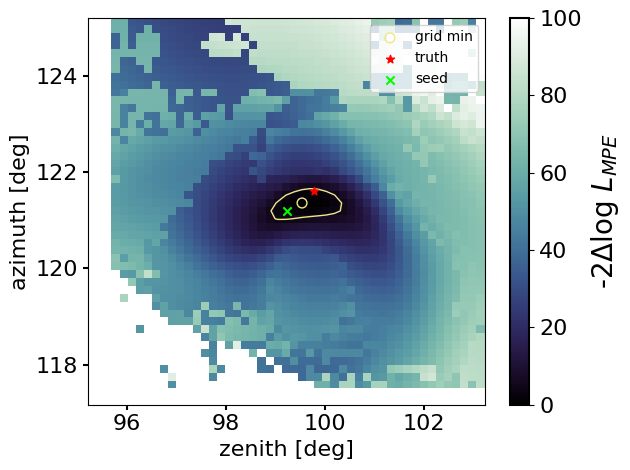

In [8]:
# Plot.

fig, ax = plt.subplots()
min_logl = np.amin(logls)
delta_logl = logls - np.amin(logls)
pc = ax.pcolormesh(np.rad2deg(X), np.rad2deg(Y), delta_logl, vmin=0, vmax=np.min([100, 1.2*np.amax(delta_logl)]), shading='auto', cmap=cx)
cbar = fig.colorbar(pc)
cbar.ax.tick_params(labelsize=16)
cbar.ax.get_yaxis().labelpad = 5
cbar.set_label("-2$\\Delta$log $L_{MPE}$", fontsize=20)
cbar.outline.set_linewidth(1.5)

contours = [4.61]
ix1, ix2 = np.where(delta_logl==0)
ax.scatter(np.rad2deg([X[ix1, ix2]]), np.rad2deg([Y[ix1, ix2]]), s=50, marker='o', facecolors='none', edgecolors='khaki', zorder=100., label='grid min')
ct = plt.contour(np.rad2deg(X), np.rad2deg(Y), delta_logl, levels=contours, linestyles=['solid'], colors=['khaki'], linewidths=1.0)

ax.scatter(np.rad2deg(true_src[0]), np.rad2deg(true_src[1]), marker="*", color='red', label="truth", zorder=200)
ax.scatter(np.rad2deg(track_src[0]), np.rad2deg(track_src[1]), marker="x", color='lime', label="seed", zorder=200)

ax.set_xlabel("zenith [deg]", fontsize=16)
ax.set_ylabel("azimuth [deg]", fontsize=16)
ax.set_xlim(np.rad2deg([track_src[0]-dzen, track_src[0]+dzen]))
ax.set_ylim(np.rad2deg([track_src[1]-dazi, track_src[1]+dazi]))
ax.tick_params(axis='both', which='both', width=1.5, colors='0.0', labelsize=16)

plt.legend()
plt.tight_layout()

In [9]:
# Setup scanner to be more stable against local minima

scan_llh_robust = get_scanner(
                        neg_llh,
                        use_multiple_vertex_seeds=True, 
                        prescan_time=False
                    )

In [10]:
# Run the scan.
solution = scan_llh_robust(X, Y, track_pos, track_time, fitting_event_data, n_splits) 
sol_logl, sol_vertex, sol_time = solution
logls = sol_logl.reshape(X.shape)

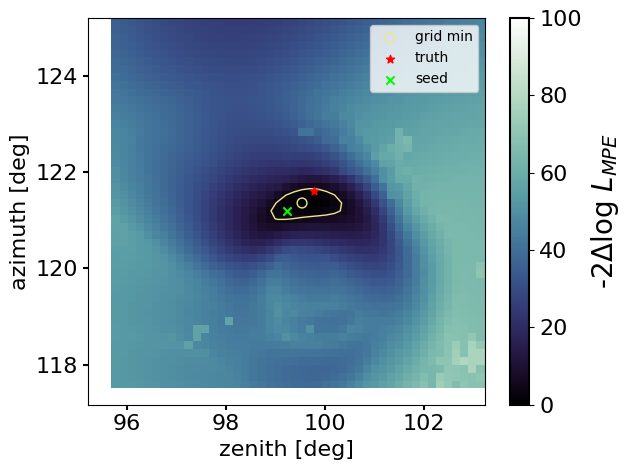

In [11]:
# Plot.

fig, ax = plt.subplots()
min_logl = np.amin(logls)
delta_logl = logls - np.amin(logls)
pc = ax.pcolormesh(np.rad2deg(X), np.rad2deg(Y), delta_logl, vmin=0, vmax=np.min([100, 1.2*np.amax(delta_logl)]), shading='auto', cmap=cx)
cbar = fig.colorbar(pc)
cbar.ax.tick_params(labelsize=16)
cbar.ax.get_yaxis().labelpad = 5
cbar.set_label("-2$\\Delta$log $L_{MPE}$", fontsize=20)
cbar.outline.set_linewidth(1.5)

contours = [4.61]
ix1, ix2 = np.where(delta_logl==0)
ax.scatter(np.rad2deg([X[ix1, ix2]]), np.rad2deg([Y[ix1, ix2]]), s=50, marker='o', facecolors='none', edgecolors='khaki', zorder=100., label='grid min')
ct = plt.contour(np.rad2deg(X), np.rad2deg(Y), delta_logl, levels=contours, linestyles=['solid'], colors=['khaki'], linewidths=1.0)

ax.scatter(np.rad2deg(true_src[0]), np.rad2deg(true_src[1]), marker="*", color='red', label="truth", zorder=200)
ax.scatter(np.rad2deg(track_src[0]), np.rad2deg(track_src[1]), marker="x", color='lime', label="seed", zorder=200)

ax.set_xlabel("zenith [deg]", fontsize=16)
ax.set_ylabel("azimuth [deg]", fontsize=16)
ax.set_xlim(np.rad2deg([track_src[0]-dzen, track_src[0]+dzen]))
ax.set_ylim(np.rad2deg([track_src[1]-dazi, track_src[1]+dazi]))
ax.tick_params(axis='both', which='both', width=1.5, colors='0.0', labelsize=16)

plt.legend()
plt.tight_layout()

In [12]:
# Potential for additional stability via prescanning optimal vertex time

scan_llh_most_robust = get_scanner(
                        neg_llh,
                        use_multiple_vertex_seeds=True, 
                        prescan_time=True
                    )

In [13]:
# Run the scan.
solution = scan_llh_most_robust(X, Y, track_pos, track_time, fitting_event_data, n_splits) 
sol_logl, sol_vertex, sol_time = solution
logls = sol_logl.reshape(X.shape)

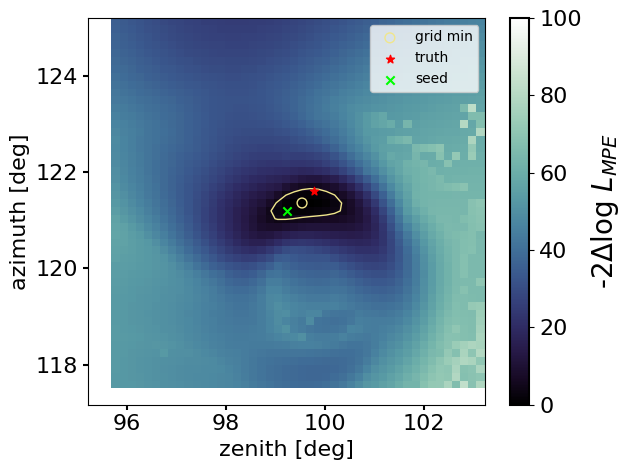

In [14]:
# Plot.

fig, ax = plt.subplots()
min_logl = np.amin(logls)
delta_logl = logls - np.amin(logls)
pc = ax.pcolormesh(np.rad2deg(X), np.rad2deg(Y), delta_logl, vmin=0, vmax=np.min([100, 1.2*np.amax(delta_logl)]), shading='auto', cmap=cx)
cbar = fig.colorbar(pc)
cbar.ax.tick_params(labelsize=16)
cbar.ax.get_yaxis().labelpad = 5
cbar.set_label("-2$\\Delta$log $L_{MPE}$", fontsize=20)
cbar.outline.set_linewidth(1.5)

contours = [4.61]
ix1, ix2 = np.where(delta_logl==0)
ax.scatter(np.rad2deg([X[ix1, ix2]]), np.rad2deg([Y[ix1, ix2]]), s=50, marker='o', facecolors='none', edgecolors='khaki', zorder=100., label='grid min')
ct = plt.contour(np.rad2deg(X), np.rad2deg(Y), delta_logl, levels=contours, linestyles=['solid'], colors=['khaki'], linewidths=1.0)

ax.scatter(np.rad2deg(true_src[0]), np.rad2deg(true_src[1]), marker="*", color='red', label="truth", zorder=200)
ax.scatter(np.rad2deg(track_src[0]), np.rad2deg(track_src[1]), marker="x", color='lime', label="seed", zorder=200)

ax.set_xlabel("zenith [deg]", fontsize=16)
ax.set_ylabel("azimuth [deg]", fontsize=16)
ax.set_xlim(np.rad2deg([track_src[0]-dzen, track_src[0]+dzen]))
ax.set_ylim(np.rad2deg([track_src[1]-dazi, track_src[1]+dazi]))
ax.tick_params(axis='both', which='both', width=1.5, colors='0.0', labelsize=16)

plt.legend()
plt.tight_layout()